In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm

# Load the data
got_ads_data = pd.read_csv('ads_noads.csv')
got_ads_data


,fullname,po.noad
0,Daenerys Targaryen,52
1,Jon Snow,54
2,Sandor Clegane,66
3,Tyrion Lannister,79
4,Cersei Lannister,68
5,Arya Stark,59
6,Sansa Stark,0
7,Joffrey Baratheon,74
8,Khal Drogo,0
9,Melisandre,70


In [8]:

# Define the true effect
true_effect = 0

# Calculate the true Average Treatment Effect (ATE)
got_ads_data['po.withad'] = got_ads_data['po.noad'] + true_effect

true_ate = np.mean(got_ads_data['po.withad']) - np.mean(got_ads_data['po.noad'])

print("The true ATE is", true_ate)


The true ATE is 0.0


In [9]:

# Set the random seed
np.random.seed(234)

# Get the number of heroes (rows)
num_people = len(got_ads_data)

# Assign treatment randomly
treatment = np.random.randint(2, size=num_people)

# Fill in the outcomes according to randomized treatment status
outcome = np.where(treatment == 1, got_ads_data['po.withad'], got_ads_data['po.noad'])

# Calculate the estimated ATE
ate_hat = np.mean(outcome[treatment == 1]) - np.mean(outcome[treatment == 0])
print("Estimated ATE is", ate_hat)


Estimated ATE is 3.707070707070706


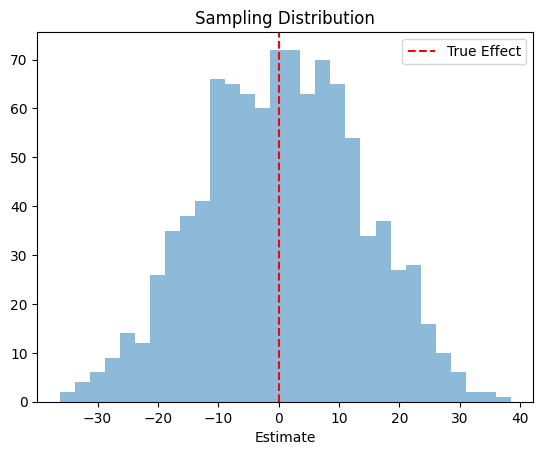

In [10]:
# Calculate the sampling distribution by replicating the randomization
def rand_est_ate():
    treatment = np.random.randint(2, size=num_people)
    outcome = np.where(treatment == 1, got_ads_data['po.withad'], got_ads_data['po.noad'])
    return np.mean(outcome[treatment == 1]) - np.mean(outcome[treatment == 0])

sampling_distribution = [rand_est_ate() for _ in range(1000)]

# Plot the sampling distribution
plt.hist(sampling_distribution, bins=30, alpha=0.5)
plt.axvline(x=true_effect, color='red', linestyle='--', label='True Effect')
plt.xlabel('Estimate')
plt.title('Sampling Distribution')
plt.legend()
plt.show()



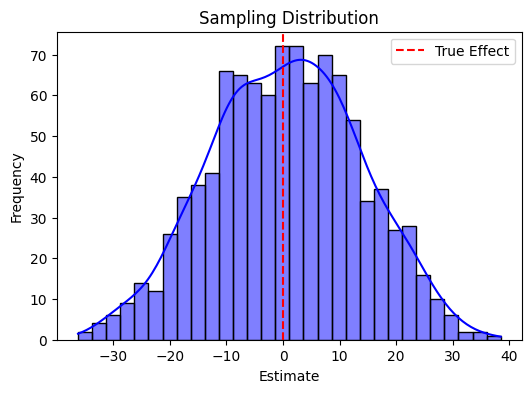

In [25]:
import seaborn as sns

# Create a histogram using Seaborn
plt.figure(figsize=(6, 4))
sns.histplot(sampling_distribution, bins=30, kde=True, color='blue', alpha=0.5)

# Add a vertical dashed line for the true effect
plt.axvline(x=true_effect, color='red', linestyle='--', label='True Effect')

# Set axis labels and title
plt.xlabel('Estimate')
plt.ylabel('Frequency')
plt.title('Sampling Distribution')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [11]:
# Calculate the standard error and 95% confidence interval
se = np.std(sampling_distribution)
print("The standard error is", se)


The standard error is 13.168290499593077


In [12]:

avg_estimate = np.mean(sampling_distribution)
conf_int = (avg_estimate - 1.96 * se, avg_estimate + 1.96 * se)
print("95% Confidence Interval:", conf_int)


95% Confidence Interval: (-25.300247797450847, 26.31945096095401)


In [13]:

# Calculate p-value
p_value = np.mean(np.abs(sampling_distribution) > np.abs(ate_hat))
print("The p-value is", p_value)



The p-value is 0.795


In [17]:
# Statistical Power
from statsmodels.stats.power import TTestPower

true_effect = 1
sd_outcome = .5*np.std(outcome)
n = TTestPower().solve_power(effect_size = true_effect/sd_outcome,
                            nobs = None, alpha = .05, power = 0.8, alternative='two-sided')

print(f"Necessary sample size: {np.ceil(n)}")



Necessary sample size: 6041.0


In [20]:
TTestPower().power(effect_size = true_effect / sd_outcome,
                    alpha = .05, nobs = 6000, alternative='two-sided')

0.7973702778273677

In [22]:
TTestPower().solve_power(effect_size = None, 
                                         power = 0.8, 
                                         alpha = 0.05,
                                         nobs = 2000)

0.06267290291902869

In [3]:
# Scratch code:
import pandas as pd

ads_data = {
    'fullname': ['Daenerys Targaryen', 'Jon Snow', 'Sandor Clegane', 'Tyrion Lannister', 'Cersei Lannister', 'Arya Stark', 'Sansa Stark'],
    'sales ($)': [52, 54, 66, 79, 68, 59, 0],
    'location': ["King’s Landing", "Winterfell", "King’s Landing", "Winterfell", "King’s Landing", "Winterfell", "Winterfell"],
    'conversion': [1, 1, 1, 1, 1, 1, 0],
    'num_items_purchased': [1, 5, 1, 2, 3, 2, 0],
    'treatment': [0, 1, 1, 1, 1, 0, 0]
}

ads_data = pd.DataFrame(ads_data)
ads_data.groupby('location').agg(click_rate=('conversion', 'mean'))



,click_rate
location,
King’s Landing,1.00
Winterfell,0.75


In [6]:
ads_data['avg_price_per_item'] = ads_data['sales ($)'] / ads_data['num_items_purchased']
ads_data

,fullname,sales ($),location,conversion,num_items_purchased,treatment,avg_price_per_item
0,Daenerys Targaryen,52,King’s Landing,1,1,0,52.000000
1,Jon Snow,54,Winterfell,1,5,1,10.800000
2,Sandor Clegane,66,King’s Landing,1,1,1,66.000000
3,Tyrion Lannister,79,Winterfell,1,2,1,39.500000
4,Cersei Lannister,68,King’s Landing,1,3,1,22.666667
5,Arya Stark,59,Winterfell,1,2,0,29.500000
6,Sansa Stark,0,Winterfell,0,0,0,NaN


In [9]:
treatment_group_sales = ads_data[ads_data['treatment'] == 1]['sales ($)'].mean()
control_group_sales = ads_data[ads_data['treatment'] == 0]['sales ($)'].mean()
ate_on_sales = treatment_group_sales - control_group_sales
ate_on_sales


29.75

In [19]:
import statsmodels.formula.api as smf
ads_data['sales'] = ads_data['sales ($)']

# Define the model using formula notation
model_formula = 'sales ~ treatment + conversion + location'

# Fit the model
model = smf.ols(formula=model_formula, data=ads_data).fit(cov_type='HC1')

# Print the summary of the model with robust standard errors
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     451.3
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           0.000176
Time:                        09:05:05   Log-Likelihood:                -23.453
No. Observations:                   7   AIC:                             54.91
Df Residuals:                       3   BIC:                             54.69
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2

/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
